In [1]:
!pip install numpy opencv-python scikit-image scikit-learn matplotlib networkx

In [2]:
!nvidia-smi

Wed Apr 23 05:00:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip install nvidia-cuda-runtime-cu12
!pip install cupy-cuda12x

In [4]:
import cv2
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from skimage.feature import graycomatrix, graycoprops
from skimage.morphology import skeletonize, binary_dilation, disk
from scipy.ndimage import distance_transform_edt
from sklearn.cluster import KMeans
from skimage.draw import ellipse_perimeter
from math import acos, degrees

In [5]:
def compute_glcm_features(image, distances=[1], angles=[0]):
    image_np = cp.asnumpy(image)  # skimage expects numpy
    glcm = graycomatrix(image_np, distances=distances, angles=angles, symmetric=True, normed=True)
    features = np.stack([
        graycoprops(glcm, 'contrast')[0, 0],
        graycoprops(glcm, 'homogeneity')[0, 0],
        graycoprops(glcm, 'ASM')[0, 0]
    ], axis=-1)
    return features

In [6]:
def generate_roi_from_texture(image, window_size=9, n_clusters=2):
    h, w = image.shape
    patches = []
    coords = []

    for i in range(0, h - window_size, window_size):
        for j in range(0, w - window_size, window_size):
            patch = image[i:i+window_size, j:j+window_size]
            feat = compute_glcm_features(patch)
            patches.append(feat)
            coords.append((i, j))

    patches = np.array(patches)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(patches)

    label_map = np.zeros((h, w), dtype=np.uint8)
    for (i, j), label in zip(coords, kmeans.labels_):
        label_map[i:i+window_size, j:j+window_size] = label
    return label_map

In [7]:
def edge_detection(image):
    image_cp = cp.asarray(image)
    gx = cv2.Sobel(cp.asnumpy(image_cp), cv2.CV_64F, 1, 0)
    gy = cv2.Sobel(cp.asnumpy(image_cp), cv2.CV_64F, 0, 1)
    magnitude = cp.sqrt(cp.asarray(gx)**2 + cp.asarray(gy)**2)
    angle = cp.arctan2(cp.asarray(gy), cp.asarray(gx))
    return magnitude, angle

def split_roi_with_morphology(roi_mask):
    distance = distance_transform_edt(cp.asnumpy(roi_mask))
    skeleton = skeletonize(roi_mask)
    dilated = binary_dilation(skeleton, disk(1))
    return dilated.astype(np.uint8)

In [8]:
def angle_between(v1, v2):
    dot = np.dot(v1, v2)
    norm = np.linalg.norm(v1) * np.linalg.norm(v2)
    return degrees(acos(np.clip(dot / norm, -1.0, 1.0)))

def is_valid_edge_pair(p1, p2, angle_thresh=90):
    center_dist = np.linalg.norm(np.array(p1['center']) - np.array(p2['center']))
    max_dim_sum = max(p1['size']) + max(p2['size'])

    # Allow pairing if segments are not too far apart
    if center_dist > 2.5 * max_dim_sum:
        return False

    v1 = np.array(p1['midpoint']) - np.array(p1['center'])
    v2 = np.array(p2['midpoint']) - np.array(p2['center'])
    angle = angle_between(v1, v2)

    return angle >= angle_thresh

In [9]:
def extract_edge_segments(edge_img):
    contours, _ = cv2.findContours(edge_img.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    segments = []
    for cnt in contours:
        if len(cnt) >= 5:
            M = cv2.moments(cnt)
            if M["m00"] == 0:
                continue
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            segments.append({
                'contour': cnt,
                'center': (cx, cy),
                'size': cv2.boundingRect(cnt)[2:],
                'midpoint': tuple(cnt[len(cnt)//2][0])
            })
    print(f"[INFO] Edge segments extracted: {len(segments)}")
    return segments

def build_edge_graph(edge_segments):
    G = nx.Graph()
    for i, seg1 in enumerate(edge_segments):
        G.add_node(i, **seg1)
        for j, seg2 in enumerate(edge_segments[i+1:], start=i+1):
            if is_valid_edge_pair(seg1, seg2):
                G.add_edge(i, j)
    print(f"[INFO] Graph nodes: {len(G.nodes)}, edges: {len(G.edges)}")
    return G

def extract_graph_cycles(G, max_len=8):
    # Faster alternative: extract cycles from small subgraphs only
    # subgraphs = [G.subgraph(c).copy() for c in nx.connected_components(G) if len(c) <= max_len]
    # cycles = []
    # for sg in subgraphs:
    #     try:
    #         cycles.extend([cycle for cycle in nx.simple_cycles(sg.to_directed()) if 3 <= len(cycle) <= max_len])
    #     except:
    #         continue
    cycles = [cycle for cycle in nx.cycle_basis(G) if 3 <= len(cycle) <= max_len]
    # print(f"[INFO] Detected crater cycles: {len(cycles)}")
    return cycles

In [10]:
def compute_fitness_score(edge_image, ellipse):
    mask = np.zeros_like(edge_image, dtype=np.uint8)
    rr, cc = ellipse_perimeter(int(ellipse[0][1]), int(ellipse[0][0]),
                               int(ellipse[1][1] / 2), int(ellipse[1][0] / 2),
                               orientation=np.deg2rad(ellipse[2]))
    valid = (rr >= 0) & (rr < mask.shape[0]) & (cc >= 0) & (cc < mask.shape[1])
    mask[rr[valid], cc[valid]] = 1
    intersection = np.logical_and(edge_image > 0, mask).sum()
    area = mask.sum()
    return intersection / area if area > 0 else 0.0

In [26]:
def draw_edge_segments(image, segments):
    vis = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for s in segments:
        cv2.drawContours(vis, [s['contour']], -1, (0, 255, 0), 1)
    return vis

def visualize_ellipses_on_cycles(image, edge_segments, cycles, edge_img, fitness_thresh=0.35):
    vis = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for idx, cycle in enumerate(cycles):
        points = np.concatenate([edge_segments[i]['contour'] for i in cycle])
        if len(points) >= 5:
            ellipse = cv2.fitEllipse(points)
            fitness = compute_fitness_score(edge_img, ellipse)
            print(f"[Ellipse] Cycle {idx + 1}: Fitness Score = {fitness:.3f}")
            if fitness >= fitness_thresh:
                cv2.ellipse(vis, ellipse, (0, 0, 255), 2)
                x, y, w, h = cv2.boundingRect(points)
                cv2.rectangle(vis, (x, y), (x + w, y + h), (255, 255, 0), 1)
    return vis

In [54]:
def detect_and_draw_natural_craters(image, edge_segments, edge_img, compactness_thresh=0.6):
    vis = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for i, seg in enumerate(edge_segments):
        contour = seg['contour']
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        if perimeter == 0:
            continue
        compactness = 4 * np.pi * area / (perimeter ** 2)
        if compactness > compactness_thresh:
            cv2.drawContours(vis, [contour], -1, (255, 255, 0), 1)
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(vis, (x, y), (x + w, y + h), (255, 255, 255), 1)
            print(f"[Natural] Contour {i}: Area = {area:.1f}, Compactness = {compactness:.2f}")
    return vis

In [55]:
def detect_and_draw_natural_from_cycles(image, edge_segments, cycles, color=(0, 255, 0)):
    vis = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for idx, cycle in enumerate(cycles):
        contours = [edge_segments[i]['contour'] for i in cycle]
        for cnt in contours:
            cv2.drawContours(vis, [cnt], -1, color, 1)
        points = np.concatenate(contours)
        x, y, w, h = cv2.boundingRect(points)
        cv2.rectangle(vis, (x, y), (x + w, y + h), color, 1)
        print(f"[Natural-Boundary] Cycle {idx + 1}: Raw contour drawn")
    return vis

In [ ]:
from scipy.interpolate import splprep, splev

def draw_smooth_arc_from_cycle(image, edge_segments, cycles, color=(0, 255, 255), s=150.0):
    vis = image.copy()

    for idx, cycle in enumerate(cycles):
        # Collect pre-ordered contour points from all segments in the cycle
        points = []
        for i in cycle:
            cnt = edge_segments[i]['contour']
            points.extend(cnt[:, 0, :])  # flatten the contour to 2D points

        ordered_points = np.array(points, dtype=np.float64)

        # Remove near-duplicates
        ordered_points = np.unique(ordered_points, axis=0)
        if ordered_points.shape[0] < 1200:
            continue

        # Check if points are spread out enough (not flat/collinear)
        x_range = ordered_points[:, 0].max() - ordered_points[:, 0].min()
        y_range = ordered_points[:, 1].max() - ordered_points[:, 1].min()
        if x_range < 150 or y_range < 150:
            continue

        try:
            tck, _ = splprep([ordered_points[:, 0], ordered_points[:, 1]], s=s)
            u_fine = np.linspace(0, 1, 100)
            x_fine, y_fine = splev(u_fine, tck)
            smooth_curve = np.stack([np.round(x_fine).astype(int), np.round(y_fine).astype(int)], axis=-1)

            cv2.polylines(vis, [smooth_curve], isClosed=False, color=color, thickness=1)
            print(f"[Arc] Cycle {idx + 1}: Smooth arc drawn")
        except Exception as e:
            print(f"[Arc] Cycle {idx + 1}: Spline fitting failed ({e})")

    return vis



In [160]:
def run_crater_detection_pipeline(image):
    roi_map = generate_roi_from_texture(image)
    edges, _ = edge_detection(image)
    edge_mask = (edges > cp.percentile(edges, 85)).astype(cp.uint8)
    segments = extract_edge_segments(cp.asnumpy(edge_mask))
    G = build_edge_graph(segments)
    cycles = extract_graph_cycles(G)
    print(f"[INFO] Edge segments extracted: {len(segments)}")
    print(f"[INFO] Graph nodes: {len(G.nodes)}, edges: {len(G.edges)}")
    print(f"[INFO] Detected crater cycles: {len(cycles)}")
    vis_ellipses = visualize_ellipses_on_cycles(cp.asnumpy(image), segments, cycles, cp.asnumpy(edge_mask))
    vis_natural = detect_and_draw_natural_craters(cp.asnumpy(image), segments, cp.asnumpy(edge_mask))
    vis_nat = detect_and_draw_natural_from_cycles(cp.asnumpy(image),segments, cycles, color=(0, 255, 0))
    temp = cv2.addWeighted(vis_ellipses, 0.6, vis_natural, 0.4, 0)
    combined = cv2.addWeighted(temp, 0.7, vis_nat, 0.3, 0)
    vis_arc = draw_smooth_arc_from_cycle(cp.asnumpy(image), segments, cycles)
    vis_arc = cv2.resize(vis_arc, (combined.shape[1], combined.shape[0]))
    if vis_arc.ndim == 2 or vis_arc.shape[2] == 1:
        vis_arc = cv2.cvtColor(vis_arc, cv2.COLOR_GRAY2BGR)
    vis_arc = vis_arc.astype(np.uint8)
    combined = combined.astype(np.uint8)
    final = cv2.addWeighted(combined, 0.8, vis_arc, 0.5, 0)
    return final, vis_ellipses, vis_natural, vis_arc

[INFO] Edge segments extracted: 123
[INFO] Graph nodes: 123, edges: 286
[INFO] Edge segments extracted: 123
[INFO] Graph nodes: 123, edges: 286
[INFO] Detected crater cycles: 179
[Ellipse] Cycle 1: Fitness Score = 0.208
[Ellipse] Cycle 2: Fitness Score = 0.197
[Ellipse] Cycle 3: Fitness Score = 0.256
[Ellipse] Cycle 4: Fitness Score = 0.250
[Ellipse] Cycle 5: Fitness Score = 0.209
[Ellipse] Cycle 6: Fitness Score = 0.191
[Ellipse] Cycle 7: Fitness Score = 0.280
[Ellipse] Cycle 8: Fitness Score = 0.269
[Ellipse] Cycle 9: Fitness Score = 0.187
[Ellipse] Cycle 10: Fitness Score = 0.286
[Ellipse] Cycle 11: Fitness Score = 0.310
[Ellipse] Cycle 12: Fitness Score = 0.326
[Ellipse] Cycle 13: Fitness Score = 0.280
[Ellipse] Cycle 14: Fitness Score = 0.250
[Ellipse] Cycle 15: Fitness Score = 0.304
[Ellipse] Cycle 16: Fitness Score = 0.239
[Ellipse] Cycle 17: Fitness Score = 0.266
[Ellipse] Cycle 18: Fitness Score = 0.328
[Ellipse] Cycle 19: Fitness Score = 0.263
[Ellipse] Cycle 20: Fitness Scor

<ipython-input-8-1134266fd9aa>:4: RuntimeWarning: invalid value encountered in scalar divide
  return degrees(acos(np.clip(dot / norm, -1.0, 1.0)))


[Arc] Cycle 16: Smooth arc drawn
[Arc] Cycle 64: Smooth arc drawn
[Arc] Cycle 72: Smooth arc drawn
[Arc] Cycle 73: Smooth arc drawn
[Arc] Cycle 74: Smooth arc drawn
[Arc] Cycle 75: Smooth arc drawn
[Arc] Cycle 76: Smooth arc drawn
[Arc] Cycle 77: Smooth arc drawn
[Arc] Cycle 78: Smooth arc drawn
[Arc] Cycle 79: Smooth arc drawn
[Arc] Cycle 80: Smooth arc drawn
[Arc] Cycle 81: Smooth arc drawn
[Arc] Cycle 82: Smooth arc drawn
[Arc] Cycle 83: Smooth arc drawn
[Arc] Cycle 84: Smooth arc drawn
[Arc] Cycle 85: Smooth arc drawn
[Arc] Cycle 86: Smooth arc drawn
[Arc] Cycle 87: Smooth arc drawn
[Arc] Cycle 88: Smooth arc drawn
[Arc] Cycle 89: Smooth arc drawn
[Arc] Cycle 90: Smooth arc drawn
[Arc] Cycle 91: Smooth arc drawn
[Arc] Cycle 92: Smooth arc drawn
[Arc] Cycle 93: Smooth arc drawn
[Arc] Cycle 95: Smooth arc drawn
[Arc] Cycle 96: Smooth arc drawn
[Arc] Cycle 98: Smooth arc drawn
[Arc] Cycle 109: Smooth arc drawn
[Arc] Cycle 124: Smooth arc drawn
[Arc] Cycle 127: Smooth arc drawn
[Arc] C

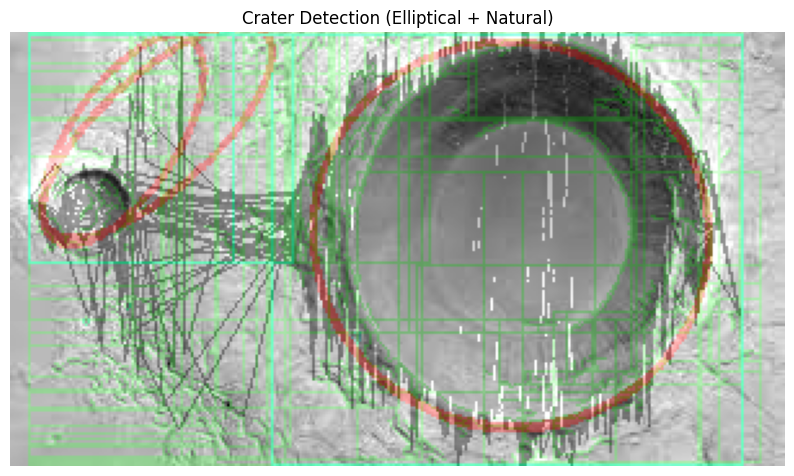

In [161]:
image = cv2.imread("/content/images (2).jpeg", cv2.IMREAD_GRAYSCALE)
image = cp.asarray(image)
result, f1, f2, f3 = run_crater_detection_pipeline(image)

plt.figure(figsize=(10, 10))
plt.imshow(result[..., ::-1])
plt.title("Crater Detection (Elliptical + Natural)")
plt.axis("off")
plt.show()


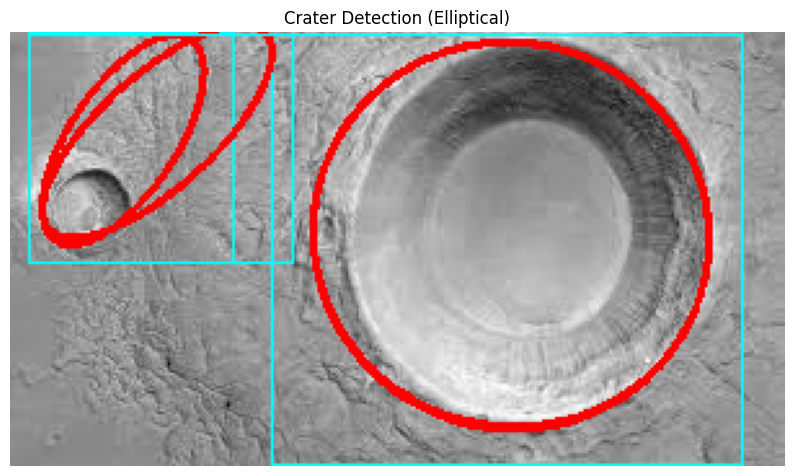

In [158]:
plt.figure(figsize=(10, 10))
plt.imshow(f1[..., ::-1])
plt.title("Crater Detection (Elliptical)")
plt.axis("off")
plt.show()

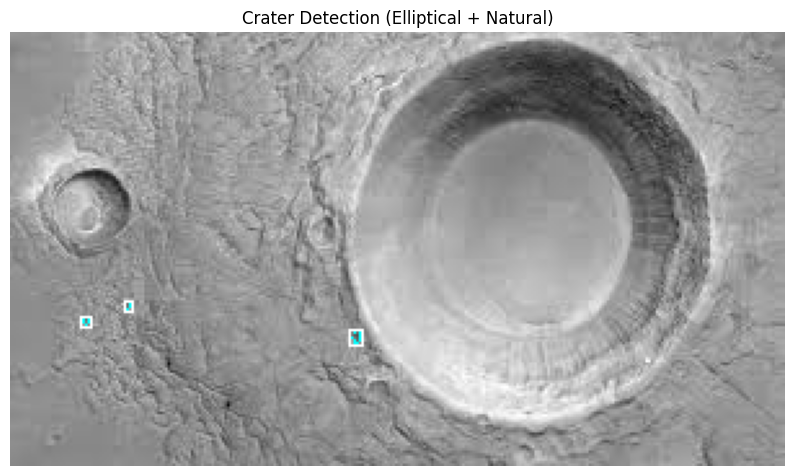

In [159]:
plt.figure(figsize=(10, 10))
plt.imshow(f2[..., ::-1])
plt.title("Crater Detection (Elliptical + Natural)")
plt.axis("off")
plt.show()